In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1: Import data into Python environment.

In [2]:
comcast_data = pd.read_csv("Dataset/Comcast_telecom_complaints_data.csv")

In [3]:
comcast_data.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No


In [4]:
comcast_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticket #                     2224 non-null   object
 1   Customer Complaint           2224 non-null   object
 2   Date                         2224 non-null   object
 3   Date_month_year              2224 non-null   object
 4   Time                         2224 non-null   object
 5   Received Via                 2224 non-null   object
 6   City                         2224 non-null   object
 7   State                        2224 non-null   object
 8   Zip code                     2224 non-null   int64 
 9   Status                       2224 non-null   object
 10  Filing on Behalf of Someone  2224 non-null   object
dtypes: int64(1), object(10)
memory usage: 191.2+ KB


In [5]:
comcast_data.duplicated().sum()

0

#### Task 1.1: Exploring the Dataset

In [6]:
comcast_data.columns

Index(['Ticket #', 'Customer Complaint', 'Date', 'Date_month_year', 'Time',
       'Received Via', 'City', 'State', 'Zip code', 'Status',
       'Filing on Behalf of Someone'],
      dtype='object')

In [7]:
comcast_data['Received Via'].unique()

array(['Customer Care Call', 'Internet'], dtype=object)

In [8]:
comcast_data['Received Via'].value_counts()

Customer Care Call    1119
Internet              1105
Name: Received Via, dtype: int64

In [9]:
top_15_city_max_complains = comcast_data['City'].value_counts()[:15]
top_15_city_min_complains = comcast_data['City'].value_counts(ascending = True)[:15]

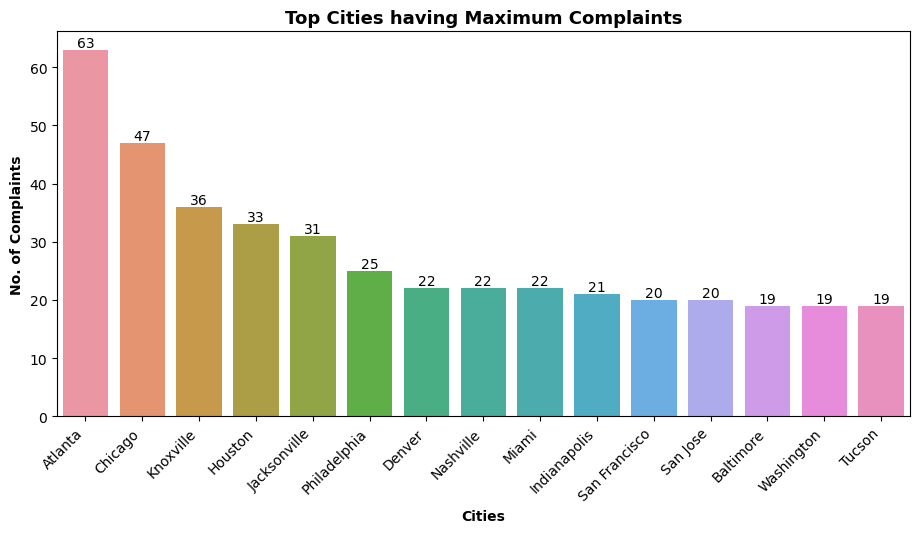

In [10]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_city_max_complains.index, y = top_15_city_max_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top Cities having Maximum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('Cities', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

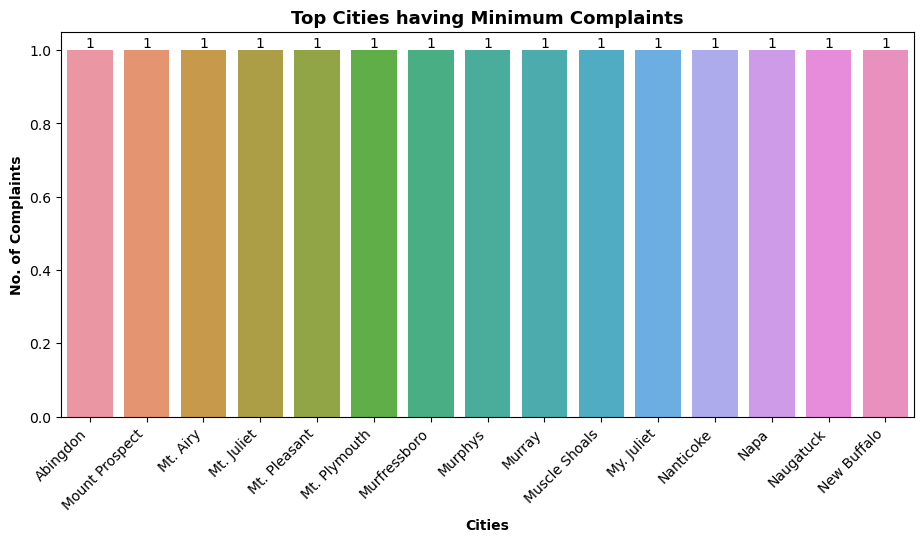

In [11]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_city_min_complains.index, y = top_15_city_min_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top Cities having Minimum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('Cities', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

In [12]:
top_15_state_max_complains = comcast_data['State'].value_counts()[:15]
top_15_state_min_complains = comcast_data['State'].value_counts(ascending = True)[:15]

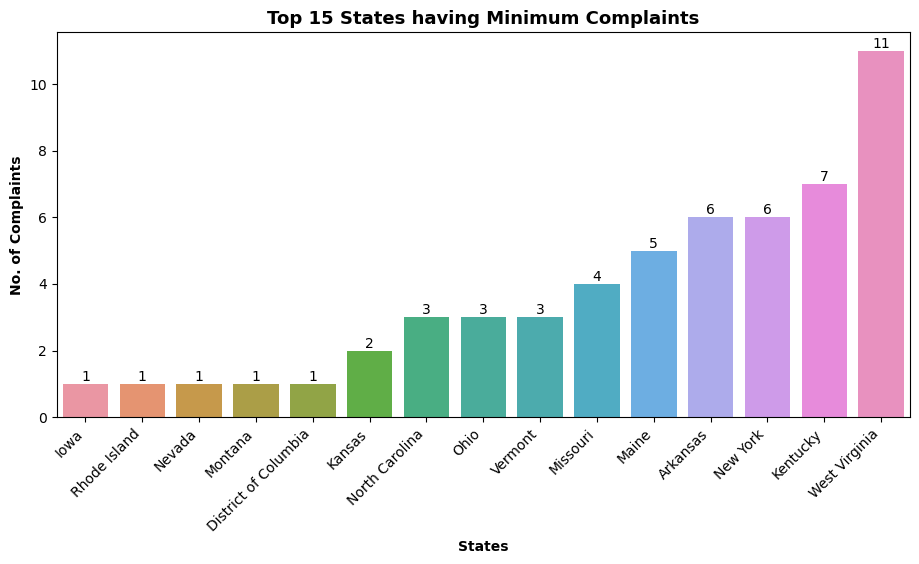

In [13]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_state_min_complains.index, y = top_15_state_min_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 States having Minimum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('States', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

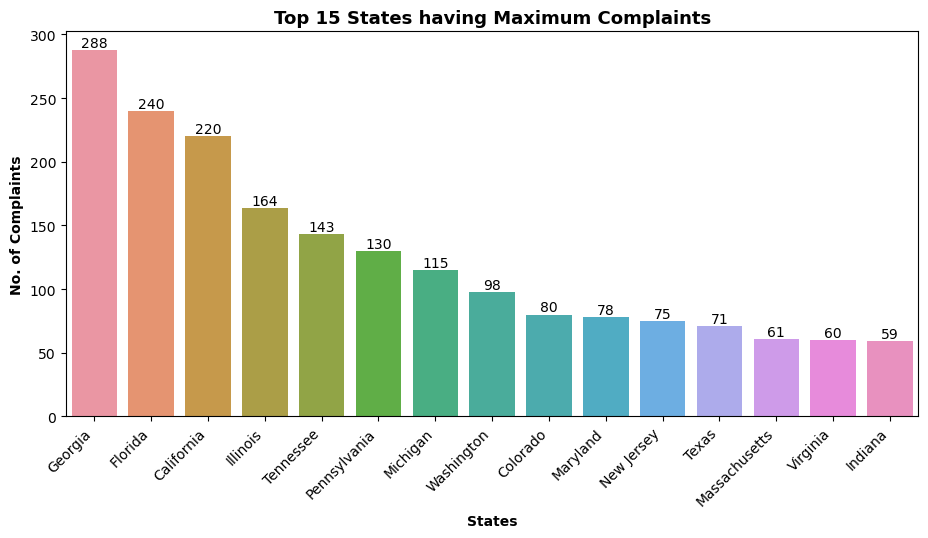

In [14]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_state_max_complains.index, y = top_15_state_max_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 States having Maximum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('States', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

In [15]:
comcast_data['Zip code'].nunique()

1543

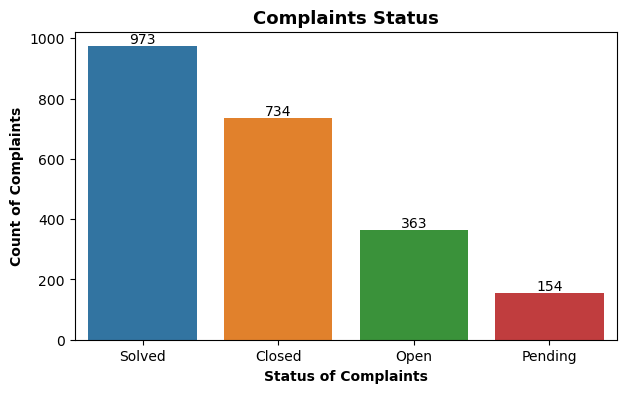

In [16]:
plt.figure(figsize=(7,4))
ax = sns.barplot(x = comcast_data['Status'].value_counts().index, y = comcast_data['Status'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.title('Complaints Status', fontsize = 13, fontweight="bold")
plt.xlabel('Status of Complaints', fontweight="bold")
plt.ylabel('Count of Complaints', fontweight="bold");

In [17]:
compaint_received_by = comcast_data['Filing on Behalf of Someone'].value_counts()
compaint_received_by

No     2021
Yes     203
Name: Filing on Behalf of Someone, dtype: int64

In [18]:
compaint_received_by.index = ['Self', 'Filed on someone\'s behalf']
compaint_received_by

Self                         2021
Filed on someone's behalf     203
Name: Filing on Behalf of Someone, dtype: int64

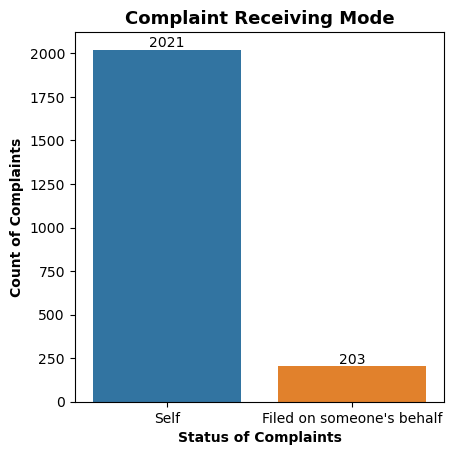

In [19]:
ax = sns.barplot(x = compaint_received_by.index, y = compaint_received_by.values)
ax.set_box_aspect(2/len(ax.patches)) #change 10 to modify the y/x axis ratio
ax.bar_label(ax.containers[0])
plt.title('Complaint Receiving Mode', fontsize = 13, fontweight="bold")
plt.xlabel('Status of Complaints', fontweight="bold")
plt.ylabel('Count of Complaints', fontweight="bold");

### Task 2: Provide the trend chart for the number of complaints at monthly and daily granularity levels.

In [20]:
comcast_data.head(3)

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes


In [21]:
comcast_data.columns

Index(['Ticket #', 'Customer Complaint', 'Date', 'Date_month_year', 'Time',
       'Received Via', 'City', 'State', 'Zip code', 'Status',
       'Filing on Behalf of Someone'],
      dtype='object')

In [22]:
comcast_data = comcast_data.drop(['Ticket #', 'Date', 'Zip code'], axis = 1)

In [23]:
comcast_data['Date_month_year'] = pd.to_datetime(comcast_data['Date_month_year'])

In [24]:
comcast_data.head(3)

,Customer Complaint,Date_month_year,Time,Received Via,City,State,Status,Filing on Behalf of Someone
0,Comcast Cable Internet Speeds,2015-04-22,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No
1,Payment disappear - service got disconnected,2015-08-04,10:22:56 AM,Internet,Acworth,Georgia,Closed,No
2,Speed and Service,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes


In [25]:
comcast_data['Day'] = comcast_data['Date_month_year'].dt.day
comcast_data['Month'] = comcast_data['Date_month_year'].dt.month_name()
comcast_data['Month_num'] = comcast_data['Date_month_year'].dt.month
comcast_data['Year'] = comcast_data['Date_month_year'].dt.year
comcast_data['Quarter'] = comcast_data['Date_month_year'].dt.quarter

In [26]:
comcast_data = comcast_data.drop(['Date_month_year'], axis = 1)

In [27]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2


In [28]:
day_wise_tickets_count = comcast_data.groupby(['Day']).count()['Customer Complaint']
day_wise_tickets_count.head()

Day
4     206
5     131
6     272
13     68
14     54
Name: Customer Complaint, dtype: int64

#### Trend Chart at Daily Granularity Level

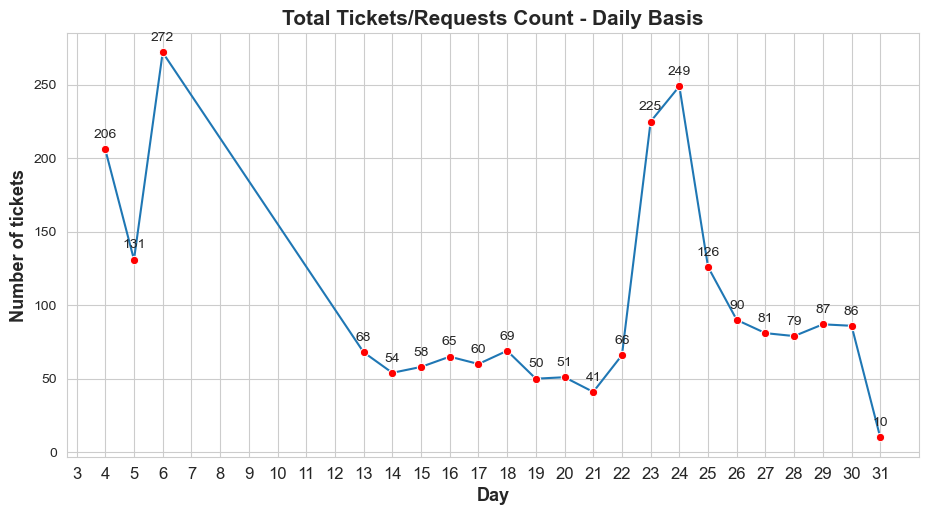

In [29]:
plt.figure(figsize=(11,5.5))
sns.set_style("whitegrid")

ax = sns.lineplot(x = day_wise_tickets_count.index, y = day_wise_tickets_count.values, marker='o', mfc = 'red')

for xval,yval in zip(day_wise_tickets_count.index, day_wise_tickets_count.values):
    ax.annotate(f'{yval}', 
                xy=(xval,yval),
                xytext=(0, 6),
                textcoords='offset points',
               ha='center', va='bottom')
    
plt.xticks(ticks=range(3, 32, 1), fontsize=12)
plt.title('Total Tickets/Requests Count - Daily Basis', fontsize=15, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('Day', fontsize=13, fontweight="bold");

In [30]:
month_wise_tickets_count = comcast_data.groupby(['Month_num', 'Month']).count()['Customer Complaint']
month_wise_tickets_count = month_wise_tickets_count.reset_index(level = 0, drop = True)
month_wise_tickets_count.head()

Month
January      55
February     59
March        45
April       375
May         317
Name: Customer Complaint, dtype: int64

#### Trend Chart at Monthly Granularity Level

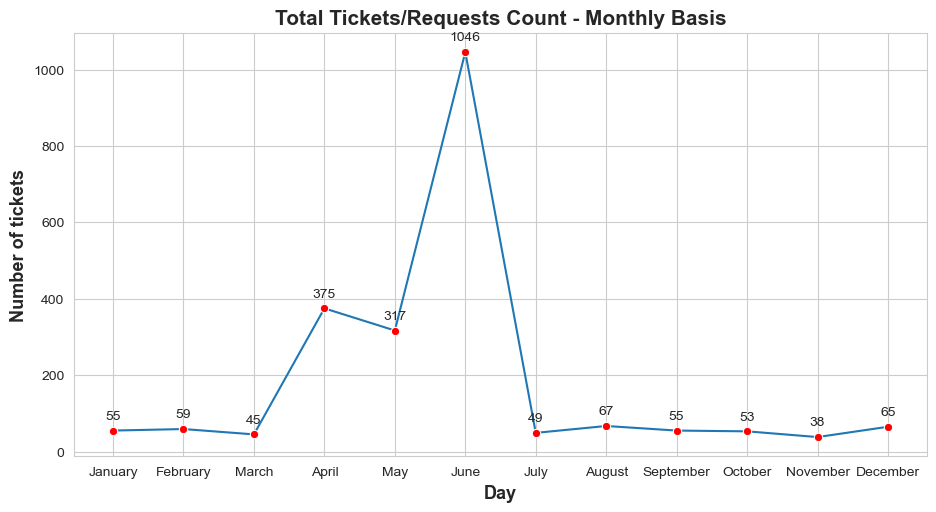

In [31]:
plt.figure(figsize=(11,5.5))
sns.set_style("whitegrid")

ax = sns.lineplot(x = month_wise_tickets_count.index, y = month_wise_tickets_count.values, marker='o', mfc = 'red')

for xval,yval in zip(month_wise_tickets_count.index, month_wise_tickets_count.values):
    ax.annotate(f'{yval}', 
                xy=(xval,yval),
                xytext=(0, 6),
                textcoords='offset points',
               ha='center', va='bottom')
    
plt.title('Total Tickets/Requests Count - Monthly Basis', fontsize=15, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('Day', fontsize=13, fontweight="bold");

### Task 3: Provide a table with the frequency of complaint types.

### Task 4: Create a new categorical variable with value as Open and Closed. 

- Open & Pending is to be categorized as **Open** and Closed & Solved is to be categorized as **Closed**.

In [32]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2


In [43]:
def assign_ticket_state(ticket_status):
    ticket_status = str(ticket_status).strip().lower()
    if (ticket_status == 'open') | (ticket_status == 'pending'):
        return 'Open'
    elif (ticket_status == 'closed') | (ticket_status == 'solved'):
        return 'Closed'
    else:
        return 'Undefined'

In [49]:
comcast_data['Ticket_State'] = comcast_data['Status'].apply(lambda x: assign_ticket_state(x))

In [50]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter,Ticket_State
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2,Closed
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3,Closed
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2,Closed


In [51]:
comcast_data['Ticket_State'].value_counts()

Closed    1707
Open       517
Name: Ticket_State, dtype: int64

In [56]:
ticket_state_percent = ((comcast_data['Ticket_State'].value_counts()/comcast_data.shape[0])*100).round(2)
ticket_state_percent

Closed    76.75
Open      23.25
Name: Ticket_State, dtype: float64

In [65]:
[0.04]*len(ticket_state_percent)

[0.04, 0.04]

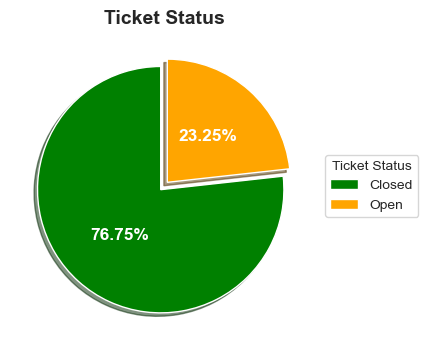

In [85]:
fig, ax = plt.subplots(figsize=[12,4])
labels = ticket_state_percent.index
wedges, texts, autopcts = ax.pie(x= ticket_state_percent, 
                        autopct="%1.2f%%",
                        explode=[0.04]*len(ticket_state_percent), 
                        #labels=labels, 
                        pctdistance=0.5,
                        shadow=True,
                        colors = ['Green', 'Orange'],
                        startangle = 90)
# Adding legend
ax.legend(wedges, ['Closed', 'Open'],
          title ="Ticket Status",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.title("Ticket Status", fontsize=14, fontweight="bold");

### Task 5: Provide state wise status of complaints in a stacked bar chart. Use the categorized variable from Q3. 

Provide insights on:
- Which state has the maximum complaints
- Which state has the highest percentage of unresolved complaints

In [86]:
comcast_data.columns

Index(['Customer Complaint', 'Time', 'Received Via', 'City', 'State', 'Status',
       'Filing on Behalf of Someone', 'Day', 'Month', 'Month_num', 'Year',
       'Quarter', 'Ticket_State'],
      dtype='object')

In [87]:
comcast_data[['Customer Complaint', 'State', 'Quarter', 'Status', 'Ticket_State']].head()

,Customer Complaint,State,Quarter,Status,Ticket_State
0,Comcast Cable Internet Speeds,Maryland,2,Closed,Closed
1,Payment disappear - service got disconnected,Georgia,3,Closed,Closed
2,Speed and Service,Georgia,2,Closed,Closed
3,Comcast Imposed a New Usage Cap of 300GB that ...,Georgia,3,Open,Open
4,Comcast not working and no service to boot,Georgia,2,Solved,Closed
